## A Deep Neural Network Model

This notebook takes the preprocessed dataset from the previous notebook and develops a DNN model to predict property violations. The preprocessing is repeated here, without the data exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

In [4]:
## Import Data ##
df_train = pd.read_csv("/Users/tal/Dropbox/Data_Science/Sample ML Project/train.csv",
                       encoding = 'ISO-8859-1')
df_test = pd.read_csv("/Users/tal/Dropbox/Data_Science/Sample ML Project/test.csv",
                       encoding = 'ISO-8859-1')
df_addresses = pd.read_csv("/Users/tal/Dropbox/Data_Science/Sample ML Project/addresses.csv",
                       encoding = 'ISO-8859-1')
df_latlon = pd.read_csv("/Users/tal/Dropbox/Data_Science/Sample ML Project/latlons.csv",
                       encoding = 'ISO-8859-1')

/anaconda/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
## Prepare initial train and test dataframes ##
df_addresses = df_addresses.merge(df_latlon, how = 'outer', on = 'address')
df_train = df_train.merge(df_addresses, how = 'inner', on = 'ticket_id')
df_train = df_train[~pd.isnull(df_train['compliance'])]
df_train = df_train.set_index('ticket_id')

df_test = df_test.merge(df_addresses, how = 'inner', on = 'ticket_id')
df_test = df_test.set_index('ticket_id')

y = df_train['compliance']

## Feature preprocessing

In [6]:
# Concatenate training and test set for consistent preprocessing
df_joint = pd.concat([df_train, df_test], copy = False)

# Select features
df_joint = df_joint[['agency_name', 'state', 'violation_code', 'disposition', 'fine_amount', 'late_fee', 
                     'discount_amount', 'lat', 'lon']]

In [7]:
def set_rare_cat_to_zero(column, min_count = 100):
    # This function changes to "other" categories with fewer occurrences than a given value.
    vc = column.value_counts()
    values_to_keep = vc[vc > min_count].index
    return column.apply (lambda x: x if x in values_to_keep else "other")  

In [8]:
# Reduce the number of categorical values
categorical_vars = ['agency_name', 'state', 'violation_code', 'disposition']
for var in categorical_vars: set_rare_cat_to_zero(df_joint[var])

In [9]:
# As the prompt for the final project indicates, there appears to be a small number of incorrect values that are outside 
# the city limits. Here, I set values that are clearly outside the city limits to the mean.

mean_lat = df_joint['lat'].mean()
mean_lon = df_joint['lon'].mean()

df_joint['lat'] = df_joint['lat'].apply(lambda x: x if (x > 42.23) and (x < 42.451) else mean_lat)  
df_joint['lon'] = df_joint['lon'].apply(lambda x: x if (x < -82.88) and (x > -83.3) else mean_lon)  

In [10]:
# Add polynomial features to geographical data
poly = prep.PolynomialFeatures(3)
lonlat_poly = poly.fit_transform(df_joint[['lat', 'lon']])
poly_names = poly.get_feature_names(input_features=['lat', 'lon'])
for i in range (3,10):
    df_joint[poly_names[i]] = lonlat_poly[:,i]

In [11]:
# Convert categorical features into dummy variables 
df_joint_dum = pd.get_dummies(df_joint, drop_first = True, sparse = True)

In [12]:
# Scale features
numerical_vars = list(df_joint_dum.columns[0:12])
scaler = prep.MinMaxScaler(feature_range = (0, 1))
df_joint_dum[numerical_vars] = scaler.fit_transform(df_joint_dum[numerical_vars])

In [13]:
# Re-split dataframe into training and test sets
df_train_processed = df_joint_dum.merge(pd.DataFrame(df_train.index), how = 'inner', right_on = 'ticket_id', 
                                        left_index = True)
df_test_processed = df_joint_dum.merge(pd.DataFrame(df_test.index), how = 'inner', right_on = 'ticket_id', 
                                       left_index = True)
df_train_processed = df_train_processed.set_index('ticket_id')
df_test_processed = df_test_processed.set_index('ticket_id')

In [14]:
# Splitting the data to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train_processed, y, test_size = 0.25, random_state = 0)

## Deep Learning Model

In [15]:
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.metrics import roc_curve, auc
import math
import time

In [16]:
# Restructure train and validation sets for DNN
X_train = X_train.values.T
X_val = X_val.values.T
Y_train = y_train.values.reshape(1,-1)
Y_val = y_val.values.reshape(1,-1)
Y_train = np.concatenate((Y_train, 1 - Y_train))
Y_val = np.concatenate((Y_val, 1 - Y_val))

In [17]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    This is a utility function from the course Improving Deep Neural Networks: Hyperparameter tuning, 
    Regularization and Optimization (by deeplearning.ai).
    
    The function creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = int(X.shape[1])                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((int(Y.shape[0]), m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [18]:
### Network Configuration ###
ops.reset_default_graph()  

print_cost = True
print_freq = 50

# Configure hyperparameters
NODES_IN_HIDDEN_LAYER_1 = 100
NODES_IN_HIDDEN_LAYER_2 = 100
LEARNING_RATE = .05
NUM_EPOCHS = 200 
MINIBATCH_SIZE = 64
REGULARIZATION_CONSTANT = 0.0001 

tf.set_random_seed(1)                             # to keep consistent results
seed = 3                                          # to keep consistent results
m = int(X_train.shape[1])                         # m : number of examples in the train set
n_x = int(X_train.shape[0])                       # n_x: input size
n_y = int(Y_train.shape[0])                       # n_y : output size 
num_minibatches = int(m/MINIBATCH_SIZE) 
costs = []  

# Create Placeholders 
X = tf.placeholder(tf.float32, shape = (n_x, None), name = 'X')
Y = tf.placeholder(tf.float32, shape = (n_y, None), name = 'Y')

# Initialize parameters  
W1 = tf.get_variable("W1", [NODES_IN_HIDDEN_LAYER_1, n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
b1 = tf.get_variable("b1", [NODES_IN_HIDDEN_LAYER_1, 1], initializer = tf.zeros_initializer(), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
W2 = tf.get_variable("W2", [NODES_IN_HIDDEN_LAYER_2, NODES_IN_HIDDEN_LAYER_1], initializer = tf.contrib.layers.xavier_initializer(seed = 1), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
b2 = tf.get_variable("b2", [NODES_IN_HIDDEN_LAYER_2, 1], initializer = tf.zeros_initializer(), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
W3 = tf.get_variable("W3", [2, NODES_IN_HIDDEN_LAYER_2], initializer = tf.contrib.layers.xavier_initializer(seed = 1), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer(), regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))

# Forward propogation
Z1 = tf.matmul(W1, tf.cast(X, tf.float32)) + b1                                   
A1 = tf.nn.relu(Z1)                                         
Z2 = tf.add(tf.matmul(W2, A1), b2)                                        
A2 = tf.nn.relu(Z2)                                           
Z3 = tf.add(tf.matmul(W3, A2), b3)                                             

# Compute costs
logits = tf.transpose(Z3)
labels = tf.transpose(Y)
# tf.get_variable('a', regularizer=tf.contrib.layers.l2_regularizer(REGULARIZATION_CONSTANT))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels)) + tf.losses.get_regularization_loss()

# Define gradient descent optimizer for backward propogation
optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE).minimize(cost)

# Initialize all the variables
init = tf.global_variables_initializer()

Cost after epoch 0: 0.235457  Time: 5.824993
Cost after epoch 50: 0.210971  Time: 225.186451
Cost after epoch 100: 0.206087  Time: 432.805540
Cost after epoch 150: 0.203960  Time: 641.934843


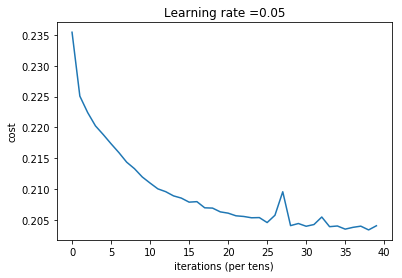

Parameters have been trained!
Train AUC is 0.8214090003194859
Test AUC is 0.8025508839091186


In [19]:
with tf.Session() as sess:

    # Run the initialization
    sess.run(init)
    
    start = time.time()

    # Do the training loop
    for epoch in range(NUM_EPOCHS):

        epoch_cost = 0.                       # Define a cost related to an epoch
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, MINIBATCH_SIZE, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
  
            epoch_cost += minibatch_cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % print_freq == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost), " Time: %f" % (time.time() - start))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(LEARNING_RATE))
    plt.show()

    print ("Parameters have been trained!")

    prediction = tf.sigmoid(Z3)    
    fpr_dnn, tpr_dnn, _ = roc_curve(y_train, prediction.eval({X: X_train, Y: Y_train})[0])
    train_auc = auc(fpr_dnn, tpr_dnn)
    fpr_dnn, tpr_dnn, _ = roc_curve(y_val, prediction.eval({X: X_val, Y: Y_val})[0])
    test_auc = auc(fpr_dnn, tpr_dnn)


    print ('Train AUC is', train_auc)    
    print ('Test AUC is', test_auc)

## Appendix - Hyperparameter Tuning
### Initial model
#### Configuration
* NODES_IN_HIDDEN_LAYER_1 = 25
* NODES_IN_HIDDEN_LAYER_2 = 12
* LEARNING_RATE = 0.0001
* NUM_EPOCHS = 1500 
* MINIBATCH_SIZE = 32
#### Results
* Time: over two hour
* Test AUC (after 100 epochs): ~.75
* Test AUC (1500 epochs): .7886
* Cost (1500) epochs: .2108

The initial model took over two hours to train and had AUC that was lower than all the other tested machine lerning models. 
### Tuning the learning rate
As a first step, I seek to increase training efficiency so I can experiment and iterate quickly. Therefore, I am starting by optimizing the learning rate. I'm running a short training (100 epochs) on the following model:
#### Configuration
* NODES_IN_HIDDEN_LAYER_1 = 100
* NODES_IN_HIDDEN_LAYER_2 = 100
* LEARNING_RATE = 0.0002
* NUM_EPOCHS = 100 
* MINIBATCH_SIZE = 64
#### Results
* Time (90): 387 sec
* Test AUC (100): .7662
* Cost (90 epochs): .2187

This model gets an AUC that is not too far from the initial model in a small fraction of the time. I keep running experiments using 50-100 epochs. 

  Architecture       | Hyperparams       | Results    
  -------------      | -------------     | --------------------
  HL1:100, HL2:100   | LR:0.0005, MBS:64 | TestAUC(100e):.7745, TrainAUC: .7772, Time(90e):367
  HL1:100, HL2:100   | LR:0.005,  MBS:64 | TestAUC(50e):.7935, TrainAUC:7935, Time(40e):164    |
  HL1:100, HL2:100   | **LR:0.05**,   MBS:64 | **TestAUC(50e):.8018**, TrainAUC:.8154, Time(40e):168    |
  HL1:100, HL2:100   | LR:0.1,    MBS:64 | TestAUC(50e):.7967, TrainAUC:.8091, Time(40e):178    |
  HL1:100, HL2:100   | LR:0.5,    MBS:64 | TestAUC(50e):.7936, TrainAUC:..8154, Time(40e):173    |
**HL#**: number of neurons in hidden layer #.  **LR**: learning rate.  **(#e)**: number of epochs after which the metric is measured.
  
The best learning rate is 0.05
### Tuning the minibatch size
 Architecture       | Hyperparams       | Results    
  -------------      | -------------     | --------------------
  HL1:100, HL2:100   | LR:0.05,  MBS:32 | TestAUC(50e):.8020, TrainAUC:.8143, Time(40e):258    |
  HL1:100, HL2:100   | LR:0.05,   **MBS:64** | TestAUC(50e):.8018, TrainAUC:.8154, Time(40e):168    |
  HL1:100, HL2:100   | LR:0.05,    MBS:128 | TestAUC(50e):.7983, TrainAUC:.8069, Time(40e):134    |
Considering both Test AUC and training time, the optimal Minibatch Size is 64. 
### Tuning the network architecture
 Architecture       | Hyperparams       | Results    
  -------------      | -------------    | --------------------
  HL1:100, HL2:100   | LR:0.05, MBS:64  | TestAUC(50e):.8018, TrainAUC:.8154, Time(40e):168    |
  HL1:500, HL2:500   | LR:0.05, MBS:64  | TestAUC(50e):.8031, TrainAUC:.8171, Time(40e):438    |
  HL1:20, HL2:20   | LR:0.05, MBS:64  | TestAUC(100e):.7857, TrainAUC:.8008, Time(90e):293    |
  HL1:50, HL2:50   | LR:0.05, MBS:64  | TestAUC(100e):.8031, TrainAUC:.8189, Time(90e):324    |
  HL1:150, HL2:72   | LR:0.05, MBS:64  | TestAUC(50e):.8018, TrainAUC:.8129, Time(40e):176    |
  HL1:100, HL2:100, HL3:100   | LR:0.05, MBS:64  | TestAUC(50e):.8008, TrainAUC:.8069, Time(40e):134    |
I could experiment more here (especially using more epochs and regularization), but a preliminary testing shows that the model with two layers of 100 each is performing well, in terms of tradeoff between AUC and training time.
### Tuning the regularization constant
I ran the model with the chosen hyperparameters with 1000 epochs, and the result indicated that it overfit: TestAUC(1000e):.8530, TrainAUC:(1000e).7533. Therefore, I added l2 regularization.

Reg Constant       | Results    | Comments
  -------------      | -------------    | --------------------
  Reg Constant: 0   |  TestAUC(50e):.8018, TrainAUC:(50e).8154, TestAUC(1000e):.7533, TrainAUC:(1000e).8530   | Benchmark with no regularization
Reg Constant: 0.001 | TrainAUC(200e):.7949, Test AUC(200e):.7900 | This model seems to underfit
Reg Constant: 0.0001 | TestAUC(100e):.8021, TrainAUC:(100e).8155, TestAUC(200e):.8025, TrainAUC:(200e).8214| TrainAUC improves, but not TestAUC: overfitting 
Reg Constant: 0.0002 | TrainAUC(200e):.8151, Test AUC(200e):.8005 | After 200 epochs, less overfitting than 0.0001.
Reg Constant: 0.0002 | TrainAUC(1000e):.8180, Test AUC(1000e):.7972 | See below

The regularization (0.0002) with 1,000 epochs yields lesser results than the unregularized model with 100 epochs. 

Overall, no DNN had a Test AUC that exceeded 0.8031. This is better than the Linear Regression model, but not as good as the Ranadom Forest and the KNN. It is possible the further tuning could improve this model. 
